# Generative Adversarial Network

We will use Generative Adversarial Network code adapted from [Rowel Atienza](https://scholar.google.com.ph/citations?user=ZkpXaOsAAAAJ&hl=en) under MIT License to create sketches in the style of humans who have played the Quick, Draw! game (data available here under Creative Commons Attribution 4.0 license). 

We will train on the Quick, Draw! dataset, which are human-generated sketches from the Quick, Draw! game.

#### Load dependencies


In [1]:
import numpy as np
import os
import io

import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape 
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D
from tensorflow.keras.optimizers import Nadam

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Upload your training images if you are using Colab. If not, you may ignore this cell.
from google.colab import files 
uploaded = files.upload()

ModuleNotFoundError: No module named 'google.colab'

#### Load data

The NumPy bitmap files that we will be used for training can be found [here](https://console.cloud.google.com/storage/quickdraw_dataset/full/numpy_bitmap). For the purpose of this example we will be training the GAN to generate sketches of dogs.

In [ ]:
response = requests.get('https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/coffee%20cup.npy')
image_path = "imgs/full_numpy_bitmap_apple.npy"
data = np.load(image_path)
data.shape

In [ ]:
data[42]

In [ ]:
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1))
img_w, img_h = data.shape[1:3]
data.shape

In [ ]:
data[42]

In [ ]:
plt.imshow(data[42,:,:,0], cmap="Greys")

### Discriminator Network

In [ ]:
def build_discriminator(depth=64, p=0.4):
    # Input layer
    image = Input((img_w, img_h,1))
    
    # Convolutional layers
    conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation='relu')(image)
    conv1 = Dropout(p)(conv1)
    conv2 = Conv2D(depth*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    conv3 = Conv2D(depth*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    conv4 = Conv2D(depth*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    # Output layer
    pred = Dense(1, activation='sigmoid')(conv4)
    
    # Model definition
    model = Model(inputs=image, outputs=pred)
    
    return model



In [8]:
discriminator = build_discriminator()
discriminator.summary()

2021-12-03 07:46:31.168443: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-03 07:46:31.169701: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 256)         0     

In [9]:
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=Nadam(lr=0.0008, clipvalue=1.0), 
                      metrics=['accuracy'])

### Generator Network

In [10]:
z_dimensions = 32

In [11]:
def build_generator(latent_dim=z_dimensions, depth=64, p=0.4):
    
    # Define inputs
    noise = Input((latent_dim,))
    
    # First dense layer
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # De-Convolutional layers
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(depth/8), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Output layer
    image = Conv2D(1, kernel_size=5, padding='same', 
                   activation='sigmoid')(conv3)

    # Model definition    
    model = Model(inputs=noise, outputs=image)
    
    return model

In [12]:
generator = build_generator()
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              103488    
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
activation (Activation)      (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0   

### Adversarial Network

In [13]:
z = Input(shape=(z_dimensions,))
img = generator(z)
discriminator.trainable = False
pred = discriminator(img)
adversarial_model = Model(z, pred)

In [14]:
adversarial_model.compile(loss='binary_crossentropy', 
                          optimizer=Nadam(lr=0.0004, clipvalue=1.0), 
                          metrics=['accuracy'])

### Time to train!

In [16]:
def train(epochs=2000, batch=128, z_dim=z_dimensions):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(1,epochs+1): 
        # sample real images: 
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        
        # generate fake images: 
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, z_dim]))
        
        # concatenate images as discriminator inputs:
        X = np.concatenate((real_imgs,fake_imgs))
        
        # assign y labels for discriminator: 
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        # train discriminator: 
        d_metrics.append(discriminator.train_on_batch(X,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        # adversarial net's noise input and "real" y: 
        noise = np.random.uniform(-1.0,1.0,size=[batch, z_dim])
        y = np.ones([batch,1])
        
        # train adversarial net: 
        a_metrics.append(adversarial_model.train_on_batch(noise,y)) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        # periodically print progress & fake images: 
        if i%20 == 0:
            print('Epoch #{}'.format(i))
            log_mesg = "%d: [Discriminator loss: %f, acc: %f]" % \
            (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [Generator loss: %f, acc: %f]" % \
            (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, z_dim])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

Epoch #19
19: [Discriminator loss: 0.203253, acc: 0.920641]  [Generator loss: 1.873956, acc: 0.271793]


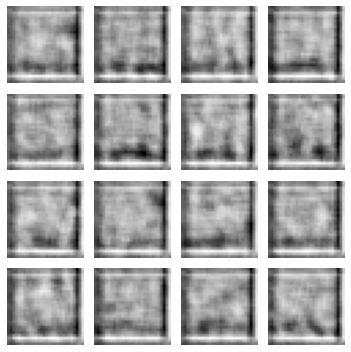

Epoch #39
39: [Discriminator loss: 0.099269, acc: 0.961338]  [Generator loss: 0.971368, acc: 0.625000]


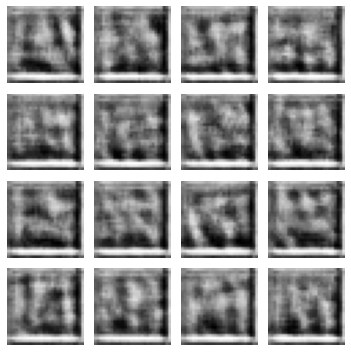

Epoch #59
59: [Discriminator loss: 0.186544, acc: 0.965109]  [Generator loss: 1.181015, acc: 0.573490]


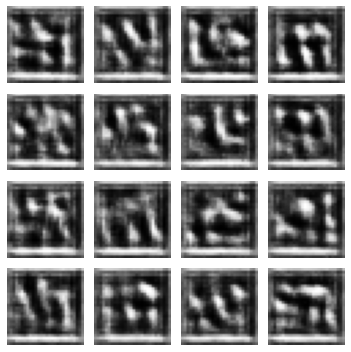

Epoch #79
79: [Discriminator loss: 0.267712, acc: 0.954856]  [Generator loss: 1.913003, acc: 0.439379]


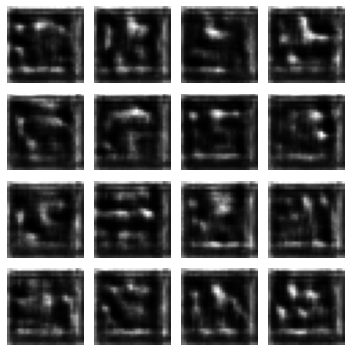

Epoch #99
99: [Discriminator loss: 0.221746, acc: 0.963147]  [Generator loss: 2.552136, acc: 0.350616]


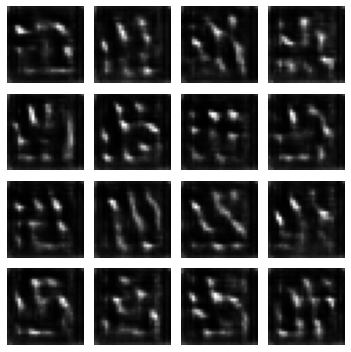

Epoch #119
119: [Discriminator loss: 0.250252, acc: 0.956473]  [Generator loss: 2.613445, acc: 0.299895]


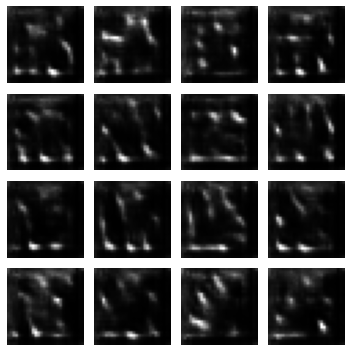

Epoch #139
139: [Discriminator loss: 0.220841, acc: 0.960853]  [Generator loss: 2.863764, acc: 0.257026]


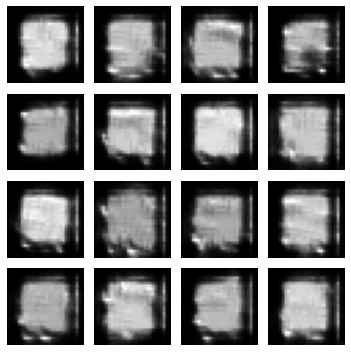

Epoch #159
159: [Discriminator loss: 0.194075, acc: 0.965605]  [Generator loss: 3.347985, acc: 0.224695]


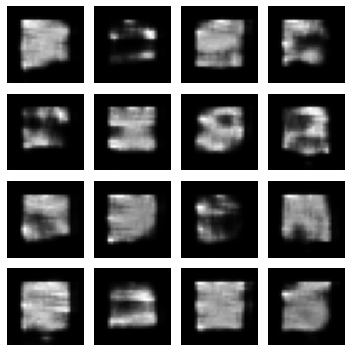

Epoch #179
179: [Discriminator loss: 0.232862, acc: 0.963294]  [Generator loss: 3.593037, acc: 0.205176]


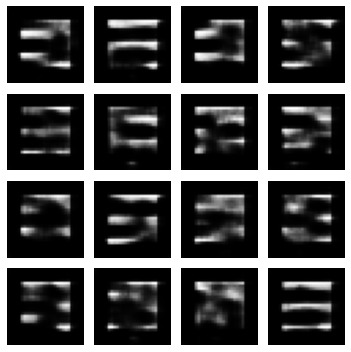

Epoch #199
199: [Discriminator loss: 0.216232, acc: 0.965433]  [Generator loss: 3.594837, acc: 0.184987]


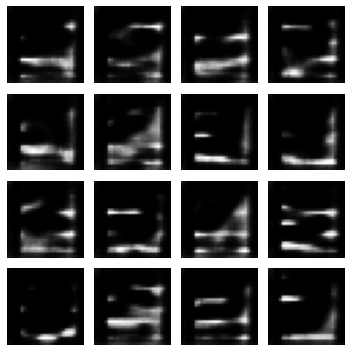

Epoch #219
219: [Discriminator loss: 0.199632, acc: 0.967662]  [Generator loss: 3.804169, acc: 0.168165]


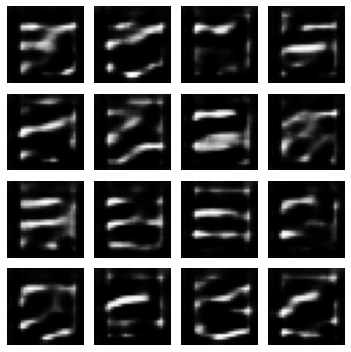

Epoch #239
239: [Discriminator loss: 0.192461, acc: 0.967214]  [Generator loss: 3.942788, acc: 0.157459]


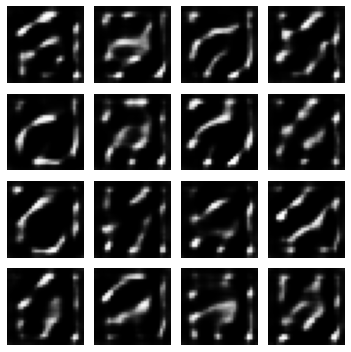

Epoch #259
259: [Discriminator loss: 0.190009, acc: 0.965553]  [Generator loss: 4.040280, acc: 0.147502]


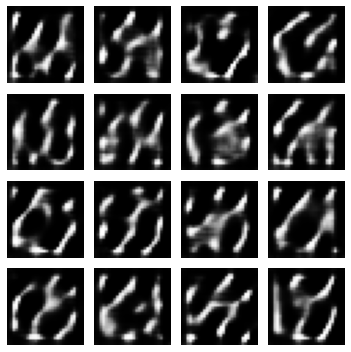

Epoch #279
279: [Discriminator loss: 0.182551, acc: 0.966090]  [Generator loss: 4.096945, acc: 0.137657]


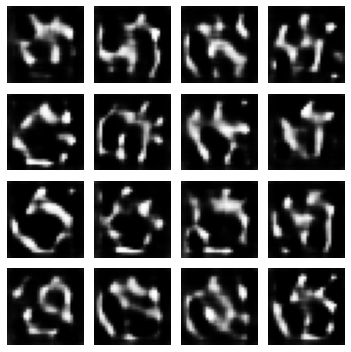

Epoch #299
299: [Discriminator loss: 0.183674, acc: 0.963864]  [Generator loss: 4.070828, acc: 0.133152]


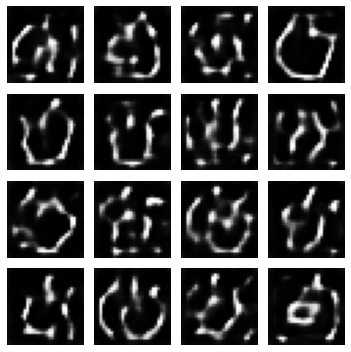

Epoch #319
319: [Discriminator loss: 0.188932, acc: 0.959444]  [Generator loss: 4.028807, acc: 0.131857]


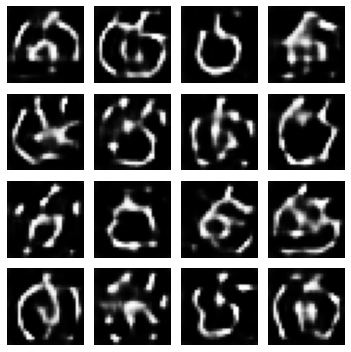

Epoch #339
339: [Discriminator loss: 0.194650, acc: 0.954830]  [Generator loss: 3.989800, acc: 0.129517]


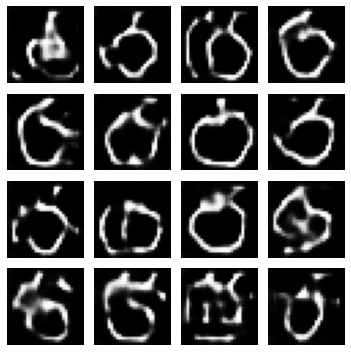

Epoch #359
359: [Discriminator loss: 0.204539, acc: 0.948163]  [Generator loss: 3.907988, acc: 0.131398]


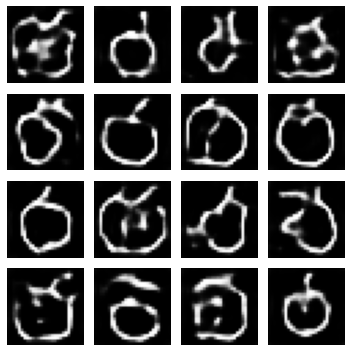

Epoch #379
379: [Discriminator loss: 0.211675, acc: 0.943138]  [Generator loss: 3.849148, acc: 0.129432]


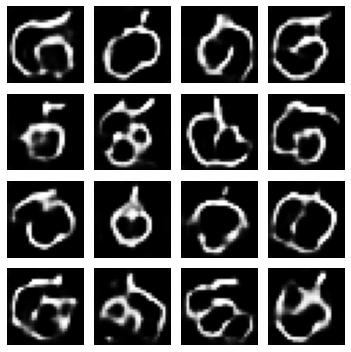

Epoch #399
399: [Discriminator loss: 0.219226, acc: 0.937657]  [Generator loss: 3.784387, acc: 0.128896]


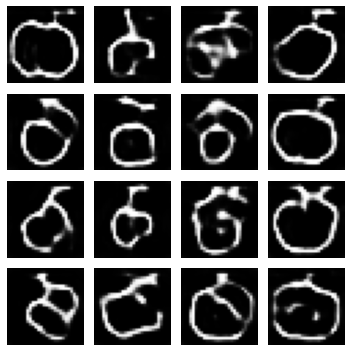

Epoch #419
419: [Discriminator loss: 0.226081, acc: 0.932941]  [Generator loss: 3.716276, acc: 0.129214]


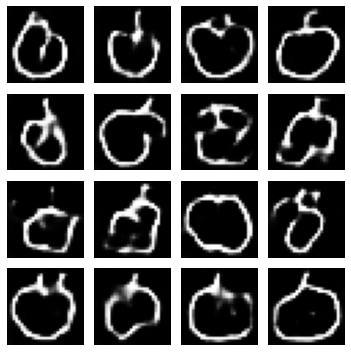

Epoch #439
439: [Discriminator loss: 0.232876, acc: 0.928166]  [Generator loss: 3.651491, acc: 0.129556]


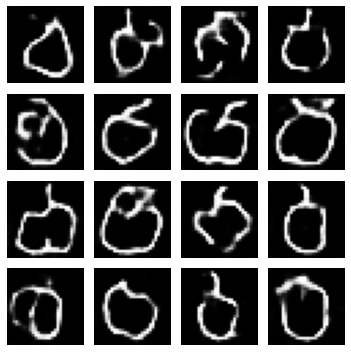

Epoch #459
459: [Discriminator loss: 0.239786, acc: 0.923671]  [Generator loss: 3.586053, acc: 0.129034]


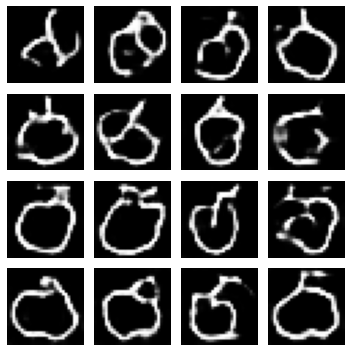

Epoch #479
479: [Discriminator loss: 0.246208, acc: 0.919453]  [Generator loss: 3.524719, acc: 0.129012]


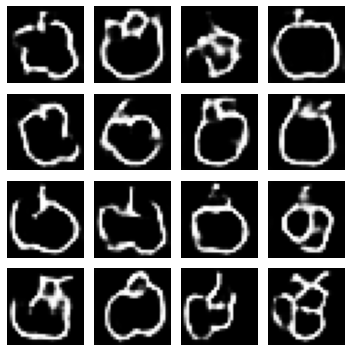

Epoch #499
499: [Discriminator loss: 0.253100, acc: 0.914947]  [Generator loss: 3.459435, acc: 0.129869]


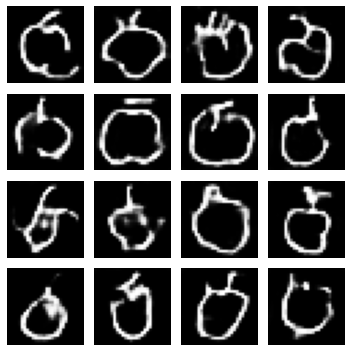

Epoch #519
519: [Discriminator loss: 0.259009, acc: 0.911195]  [Generator loss: 3.401351, acc: 0.129802]


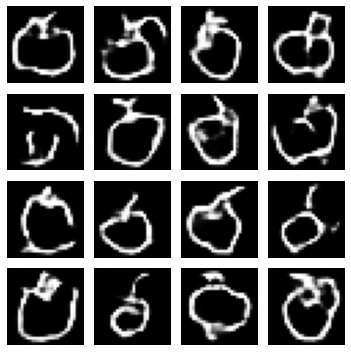

Epoch #539
539: [Discriminator loss: 0.268282, acc: 0.905525]  [Generator loss: 3.334869, acc: 0.132827]


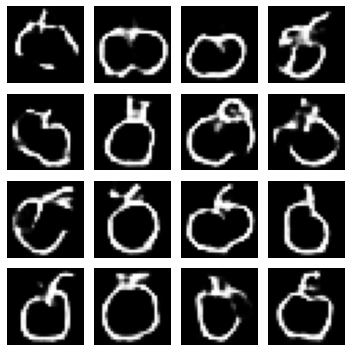

Epoch #559
559: [Discriminator loss: 0.272768, acc: 0.902595]  [Generator loss: 3.286719, acc: 0.132156]


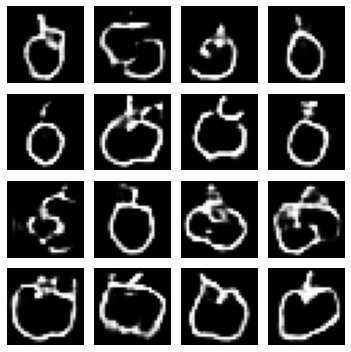

Epoch #579
579: [Discriminator loss: 0.277754, acc: 0.899342]  [Generator loss: 3.240660, acc: 0.132516]


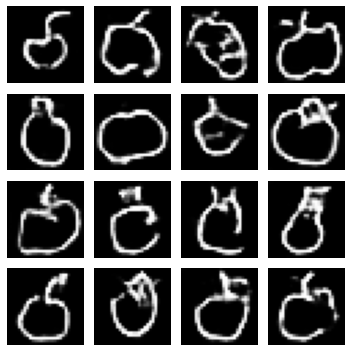

Epoch #599
599: [Discriminator loss: 0.282383, acc: 0.896259]  [Generator loss: 3.200736, acc: 0.133165]


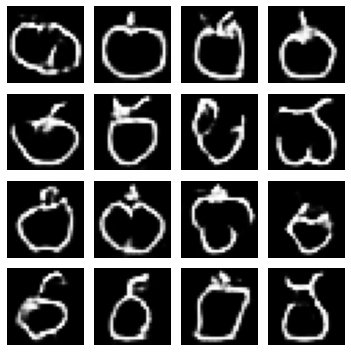

Epoch #619
619: [Discriminator loss: 0.286987, acc: 0.893345]  [Generator loss: 3.157633, acc: 0.133507]


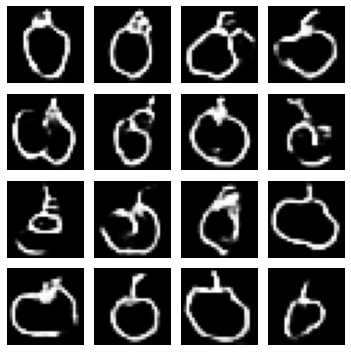

Epoch #639
639: [Discriminator loss: 0.290734, acc: 0.890821]  [Generator loss: 3.123895, acc: 0.133253]


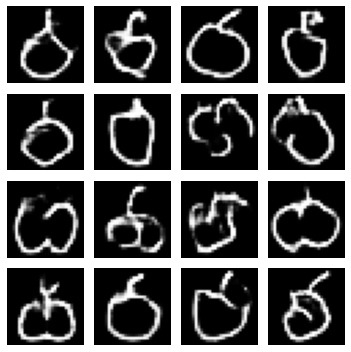

Epoch #659
659: [Discriminator loss: 0.294229, acc: 0.888456]  [Generator loss: 3.089124, acc: 0.133239]


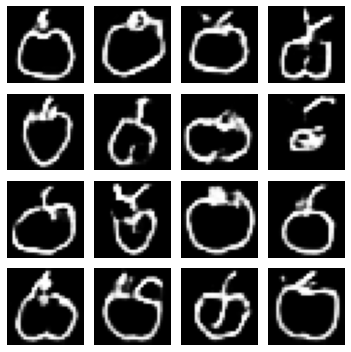

Epoch #679
679: [Discriminator loss: 0.297588, acc: 0.886270]  [Generator loss: 3.058387, acc: 0.133480]


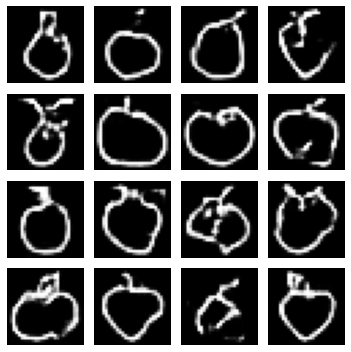

Epoch #699
699: [Discriminator loss: 0.302687, acc: 0.883114]  [Generator loss: 3.022612, acc: 0.133953]


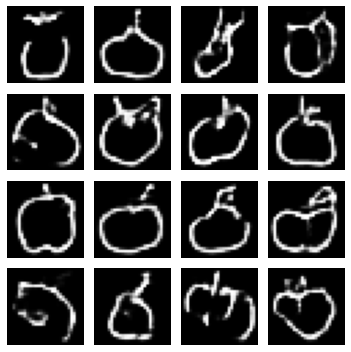

Epoch #719
719: [Discriminator loss: 0.305743, acc: 0.881090]  [Generator loss: 2.994604, acc: 0.133475]


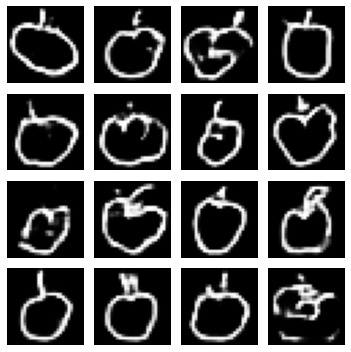

Epoch #739
739: [Discriminator loss: 0.309056, acc: 0.878970]  [Generator loss: 2.967108, acc: 0.133278]


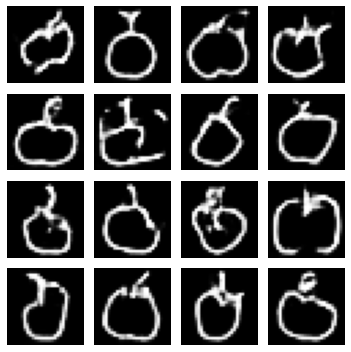

Epoch #759
759: [Discriminator loss: 0.312284, acc: 0.876683]  [Generator loss: 2.940889, acc: 0.133296]


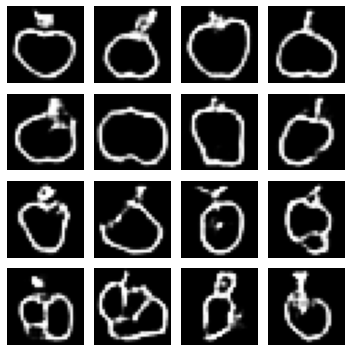

Epoch #779
779: [Discriminator loss: 0.315143, acc: 0.874789]  [Generator loss: 2.917073, acc: 0.133274]


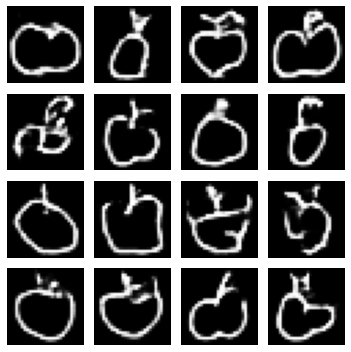

Epoch #799
799: [Discriminator loss: 0.317339, acc: 0.873274]  [Generator loss: 2.894943, acc: 0.132852]


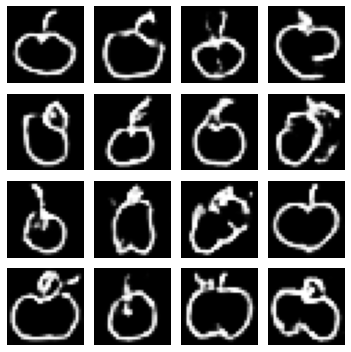

Epoch #819
819: [Discriminator loss: 0.319936, acc: 0.871566]  [Generator loss: 2.871720, acc: 0.133347]


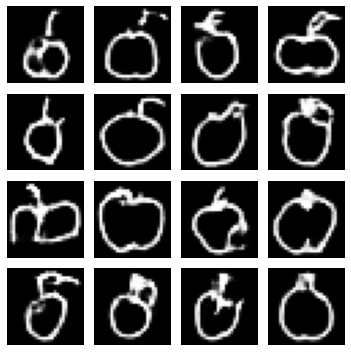

Epoch #839
839: [Discriminator loss: 0.322699, acc: 0.869823]  [Generator loss: 2.850368, acc: 0.133315]


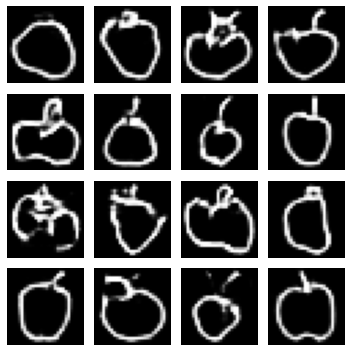

Epoch #859
859: [Discriminator loss: 0.325025, acc: 0.868365]  [Generator loss: 2.829620, acc: 0.133231]


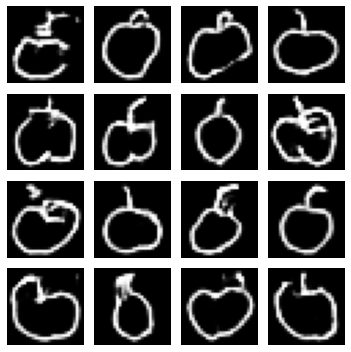

Epoch #879
879: [Discriminator loss: 0.327196, acc: 0.866876]  [Generator loss: 2.811268, acc: 0.133292]


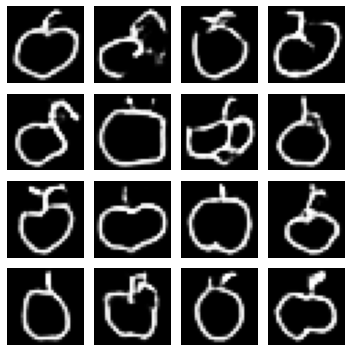

Epoch #899
899: [Discriminator loss: 0.329024, acc: 0.865693]  [Generator loss: 2.794293, acc: 0.133247]


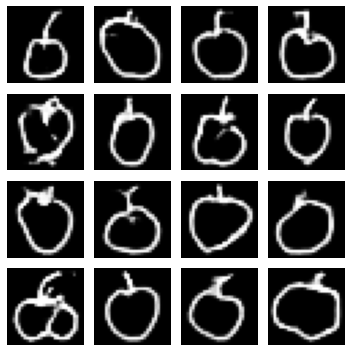

Epoch #919
919: [Discriminator loss: 0.331149, acc: 0.864306]  [Generator loss: 2.775674, acc: 0.133484]


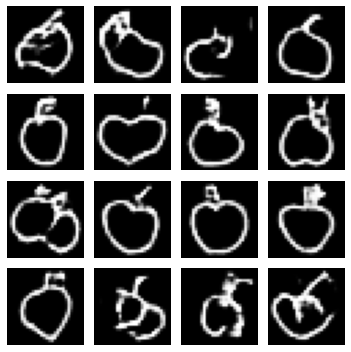

Epoch #939
939: [Discriminator loss: 0.332606, acc: 0.863290]  [Generator loss: 2.761168, acc: 0.133137]


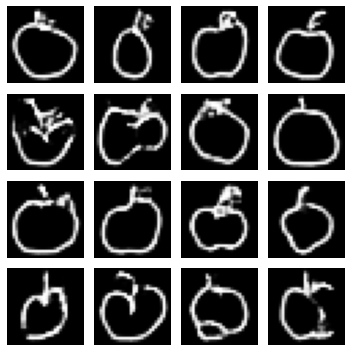

Epoch #959
959: [Discriminator loss: 0.334070, acc: 0.862283]  [Generator loss: 2.745969, acc: 0.133375]


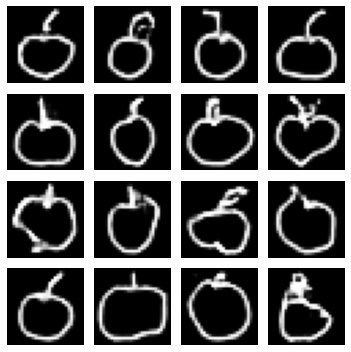

Epoch #979
979: [Discriminator loss: 0.335801, acc: 0.861194]  [Generator loss: 2.731669, acc: 0.133403]


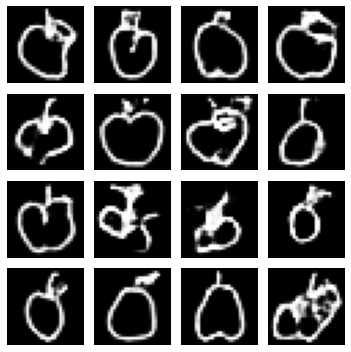

Epoch #999
999: [Discriminator loss: 0.336988, acc: 0.860368]  [Generator loss: 2.719183, acc: 0.133462]


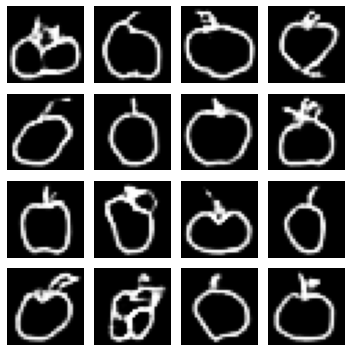

Epoch #1019
1019: [Discriminator loss: 0.338745, acc: 0.859202]  [Generator loss: 2.707552, acc: 0.133595]


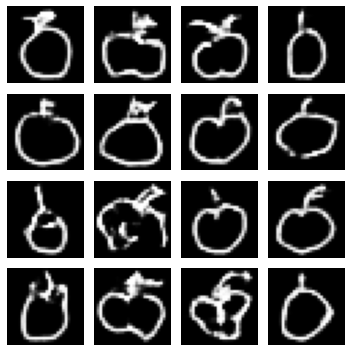

Epoch #1039
1039: [Discriminator loss: 0.339621, acc: 0.858589]  [Generator loss: 2.696350, acc: 0.133286]


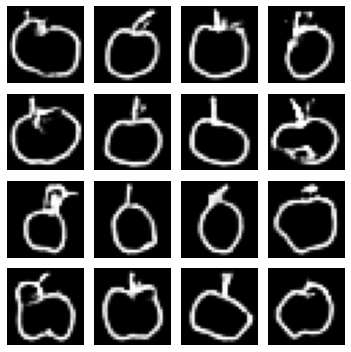

Epoch #1059
1059: [Discriminator loss: 0.340981, acc: 0.857601]  [Generator loss: 2.684824, acc: 0.133535]


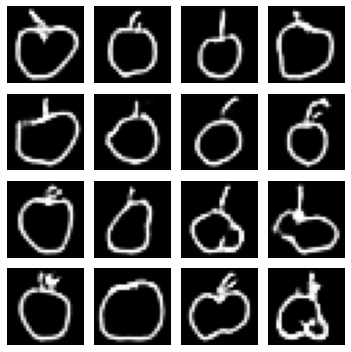

Epoch #1079
1079: [Discriminator loss: 0.342003, acc: 0.856682]  [Generator loss: 2.674626, acc: 0.133406]


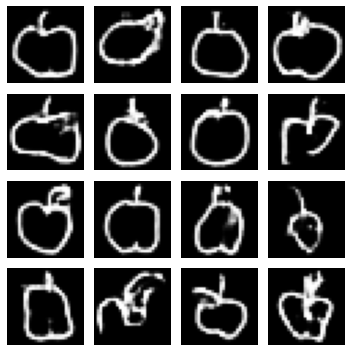

Epoch #1099
1099: [Discriminator loss: 0.342988, acc: 0.856037]  [Generator loss: 2.666042, acc: 0.133388]


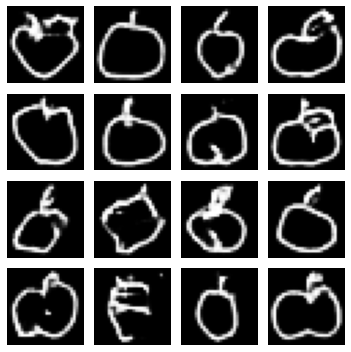

Epoch #1119
1119: [Discriminator loss: 0.344088, acc: 0.855368]  [Generator loss: 2.655838, acc: 0.133343]


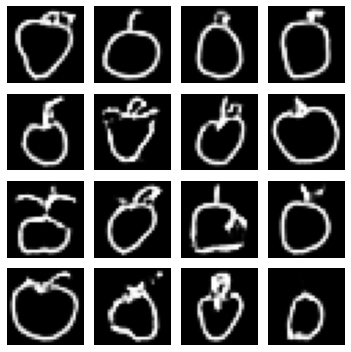

Epoch #1139
1139: [Discriminator loss: 0.344870, acc: 0.854790]  [Generator loss: 2.647839, acc: 0.133217]


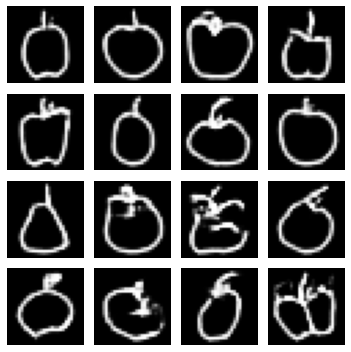

Epoch #1159
1159: [Discriminator loss: 0.345661, acc: 0.854178]  [Generator loss: 2.639517, acc: 0.133190]


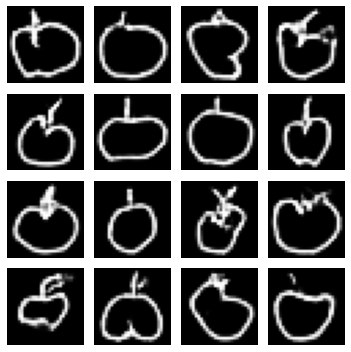

Epoch #1179
1179: [Discriminator loss: 0.345965, acc: 0.854008]  [Generator loss: 2.634579, acc: 0.132634]


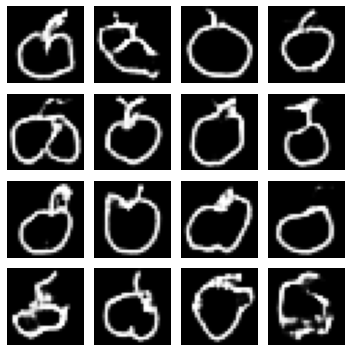

Epoch #1199
1199: [Discriminator loss: 0.346990, acc: 0.853221]  [Generator loss: 2.627515, acc: 0.132571]


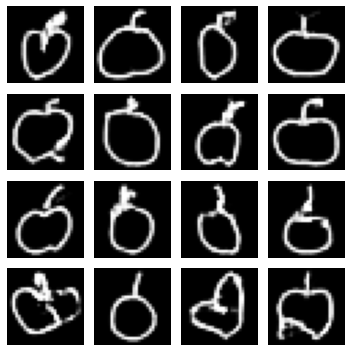

Epoch #1219
1219: [Discriminator loss: 0.347554, acc: 0.852755]  [Generator loss: 2.621842, acc: 0.132332]


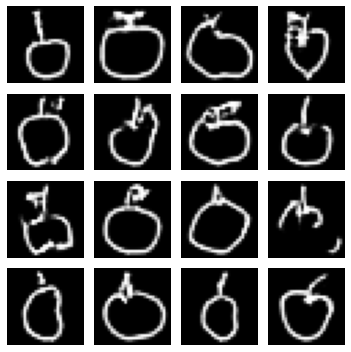

Epoch #1239
1239: [Discriminator loss: 0.347972, acc: 0.852458]  [Generator loss: 2.616954, acc: 0.132195]


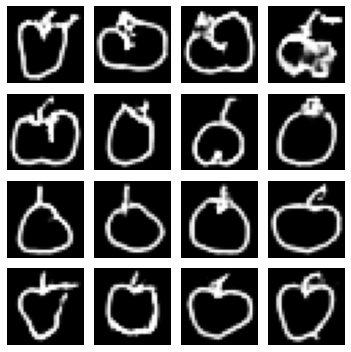

Epoch #1259
1259: [Discriminator loss: 0.348530, acc: 0.852062]  [Generator loss: 2.611581, acc: 0.131950]


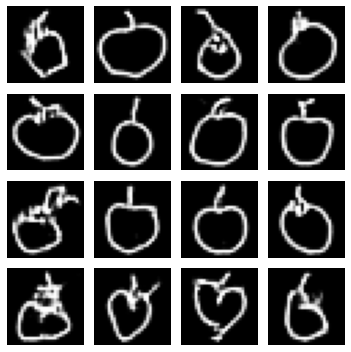

Epoch #1279
1279: [Discriminator loss: 0.349566, acc: 0.851391]  [Generator loss: 2.603485, acc: 0.131835]


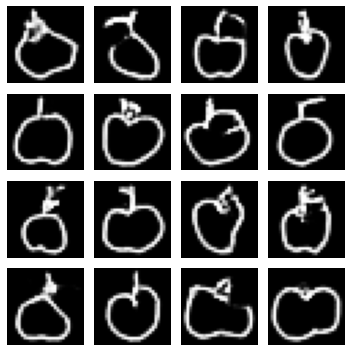

Epoch #1299
1299: [Discriminator loss: 0.349827, acc: 0.851096]  [Generator loss: 2.601159, acc: 0.131519]


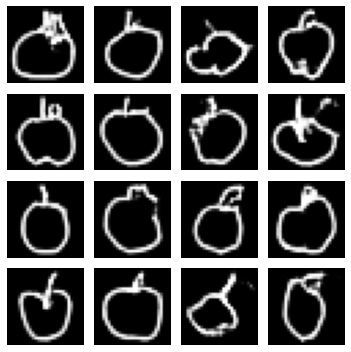

Epoch #1319
1319: [Discriminator loss: 0.349785, acc: 0.851044]  [Generator loss: 2.597824, acc: 0.131379]


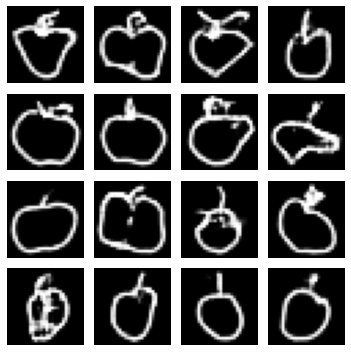

Epoch #1339
1339: [Discriminator loss: 0.350004, acc: 0.850880]  [Generator loss: 2.594815, acc: 0.131027]


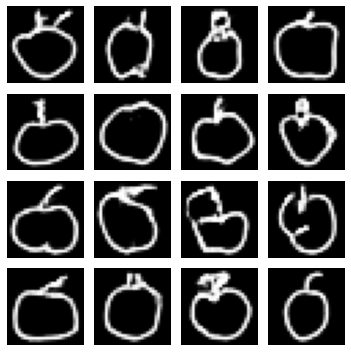

Epoch #1359
1359: [Discriminator loss: 0.350508, acc: 0.850485]  [Generator loss: 2.592610, acc: 0.130766]


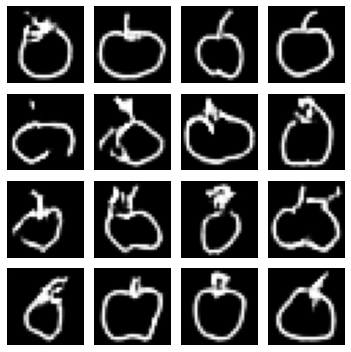

Epoch #1379
1379: [Discriminator loss: 0.350752, acc: 0.850310]  [Generator loss: 2.590120, acc: 0.130682]


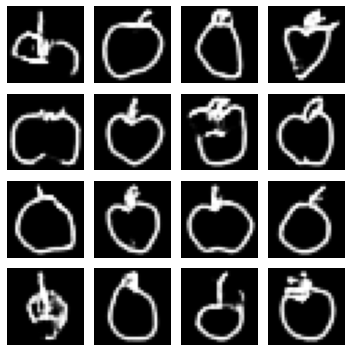

Epoch #1399
1399: [Discriminator loss: 0.350834, acc: 0.850239]  [Generator loss: 2.586576, acc: 0.130327]


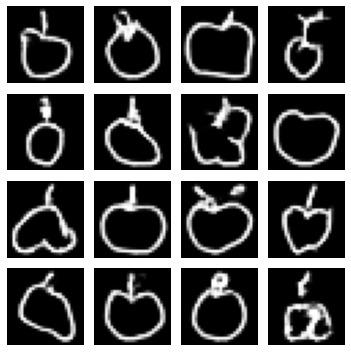

Epoch #1419
1419: [Discriminator loss: 0.350972, acc: 0.850032]  [Generator loss: 2.584573, acc: 0.130126]


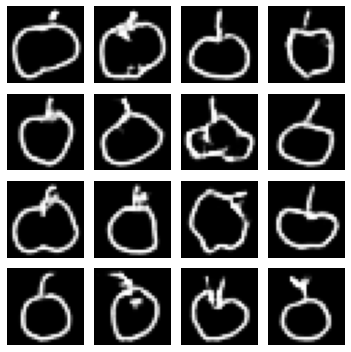

Epoch #1439
1439: [Discriminator loss: 0.351429, acc: 0.849730]  [Generator loss: 2.580993, acc: 0.130011]


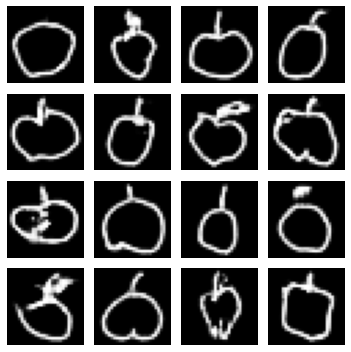

Epoch #1459
1459: [Discriminator loss: 0.351775, acc: 0.849439]  [Generator loss: 2.578348, acc: 0.129739]


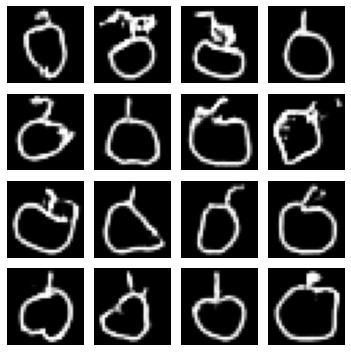

Epoch #1479
1479: [Discriminator loss: 0.351760, acc: 0.849405]  [Generator loss: 2.577003, acc: 0.129506]


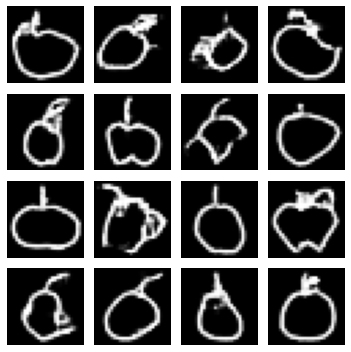

Epoch #1499
1499: [Discriminator loss: 0.351782, acc: 0.849345]  [Generator loss: 2.576426, acc: 0.129216]


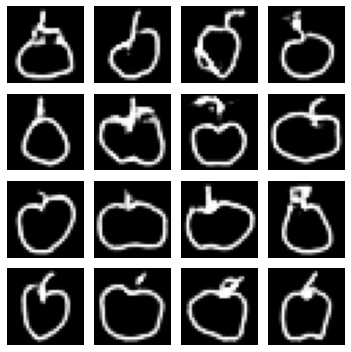

Epoch #1519
1519: [Discriminator loss: 0.351786, acc: 0.849233]  [Generator loss: 2.576510, acc: 0.129007]


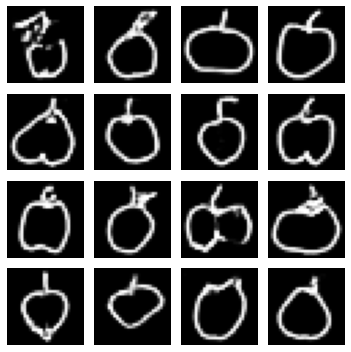

Epoch #1539
1539: [Discriminator loss: 0.351893, acc: 0.849139]  [Generator loss: 2.575453, acc: 0.128812]


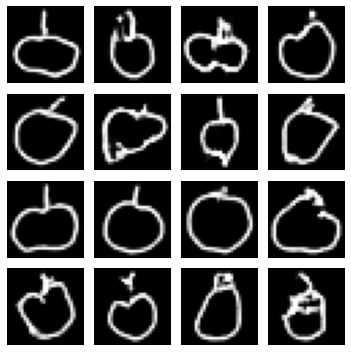

Epoch #1559
1559: [Discriminator loss: 0.351918, acc: 0.849049]  [Generator loss: 2.574330, acc: 0.128508]


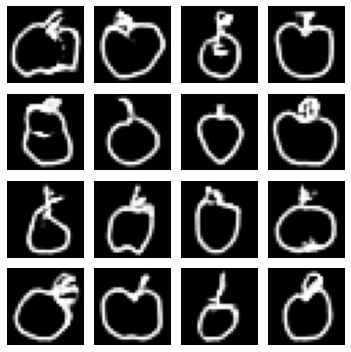

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [17]:
a_metrics_complete, d_metrics_complete = train()

In [ ]:
ax = pd.DataFrame(
    {'Generator': [metric[0] for metric in a_metrics_complete],
     'Discriminator': [metric[0] for metric in d_metrics_complete],}).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

In [ ]:
ax = pd.DataFrame(
    {'Generator': [metric[1] for metric in a_metrics_complete],
     'Discriminator': [metric[1] for metric in d_metrics_complete],}).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")